In [48]:
# Lectura datos osm
import osmium as osm

# Tratamiento de datos
import pandas as pd

# Tratamiento de datos geográficos y mapas
import geopandas as gpd
from geopy.distance import distance
from shapely.geometry import Polygon
import folium
from folium.plugins import HeatMap
from branca.element import Figure
import branca.colormap as cm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Class to Read

In [2]:
class POIHandler(osm.SimpleHandler):
    '''
    Clase para extraer información de un archivo osm.pbf. Únicamente se extraen
    elementos identificados como 'node' o 'area'. Además, se puede aplicar un filtrado
    para seleccionar únicamente aquellos que tengan tags con un determinado key y
    value.

    La posición de las áreas se obtiene calculando el centroide del polígono que
    forman sus nodos.

    TODO: 'all' value to include all available values of a tag.

    Arguments
    ---------

    custom_filter: dict
        Diccionario con los tags y valores que han de tener los elementos para
        ser extraídos. Por ejemplo:

        `{'amenity': ['restaurant', 'bar']}` selecciona únicamente aquellos
        elementos que tengan el tag 'amenity' con valor 'restaurant' o 'bar'.

        `{'amenity': ['restaurant', 'bar'], 'building': ['car']}` selecciona
        únicamente aquellos elementos que tengan el tag 'amenity' con valor
        'restaurant' o 'bar', o los que tengan el tag 'building' con valor 'hotel'.
    '''

    def __init__(self, custom_filter=None):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []
        self.custom_filter = custom_filter

        if self.custom_filter:
            for key, value in self.custom_filter.items():
                if isinstance(value, str):
                    self.custom_filter[key] = [value]

    def node(self, node):
        if self.custom_filter is None:
            name = node.tags.get('name', '')
            self.tag_inventory(node, 'node', name)
        else:
            if any([node.tags.get(key) in self.custom_filter[key] for key in self.custom_filter.keys()]):
                name = node.tags.get('name', '')
                self.tag_inventory(node, 'node', name)

    def area(self, area):
        if self.custom_filter is None:
            name = area.tags.get('name', '')
            self.tag_inventory(area, 'area', name)
        else:
            if any([area.tags.get(key) in self.custom_filter[key] for key in self.custom_filter.keys()]):
                name = area.tags.get('name', '')
                self.tag_inventory(area, 'area', name)

    def tag_inventory(self, elem, elem_type, name):
        if elem_type == 'node':
            for tag in elem.tags:
                self.osm_data.append([elem_type,
                                      elem.id,
                                      name,
                                      elem.location.lon,
                                      elem.location.lat,
                                      pd.Timestamp(elem.timestamp),
                                      len(elem.tags),
                                      tag.k,
                                      tag.v])
        if elem_type == 'area':
            try:
                # Se crea un Polygon con los nodos que forman el area para calcular
                # su centroide.
                nodes = list(elem.outer_rings())[0]
                polygon = Polygon([(node.lon, node.lat) for node in nodes])
                for tag in elem.tags:
                    self.osm_data.append([elem_type,
                                          elem.id,
                                          name,
                                          polygon.centroid.x,
                                          polygon.centroid.y,
                                          pd.Timestamp(elem.timestamp),
                                          len(elem.tags),
                                          tag.k,
                                          tag.v])
            except:
                pass

# Load Data

## Load segments csv

In [17]:
def load_segments() -> pd.DataFrame:
     colnames = ["id","lon",'lat','area_m','area_km','media_boletas','media_clientes','media_cajas','ventas','cajas','media_caja_por_venta','clientes','media_caja_por_cliente']
     df_aux = pd.read_csv('../others/Levantamiento de Información/Caracterización de hexagonos de La Paz.csv')
     df_aux.columns = colnames
     return df_aux

df = load_segments()
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      881 non-null    object 
 1   lon                     881 non-null    float64
 2   lat                     881 non-null    float64
 3   area_m                  881 non-null    float64
 4   area_km                 881 non-null    float64
 5   media_boletas           881 non-null    float64
 6   media_clientes          881 non-null    float64
 7   media_cajas             881 non-null    float64
 8   ventas                  881 non-null    float64
 9   cajas                   881 non-null    float64
 10  media_caja_por_venta    881 non-null    float64
 11  clientes                881 non-null    float64
 12  media_caja_por_cliente  881 non-null    float64
dtypes: float64(12), object(1)
memory usage: 89.6+ KB


## Load map from Bolivia

In [51]:
# Creación del mapa con una ubicación inicial
# ==============================================================================
centro_la_paz = [-16.501457, -68.149887]
fig = Figure(width=1000, height=800)
mapa = folium.Map(location=centro_la_paz, zoom_start=11)
fig.add_child(mapa)

# Segmentation

Description of dataset

In [36]:
df.describe()

,lon,lat,area_m,area_km,media_boletas,media_clientes,media_cajas,ventas,cajas,media_caja_por_venta,clientes,media_caja_por_cliente
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,-68.103021,-16.514913,111703.476264,0.111703,24.212110,8.473513,171.021809,217.608400,1537.641317,5.151939,10.881952,104.995385
std,0.035083,0.034195,69.493074,0.000069,31.008766,10.346627,312.282413,279.292885,2811.254541,7.473979,13.343611,165.430430
min,-68.171371,-16.615759,111550.134970,0.111550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-68.132563,-16.537161,111649.698789,0.111650,2.000000,1.000000,7.888889,16.000000,57.000000,2.200000,1.000000,29.000000
50%,-68.102030,-16.513488,111703.658346,0.111704,13.888889,4.777778,59.888889,125.000000,539.000000,3.716981,6.000000,72.562500
75%,-68.076689,-16.490532,111758.279993,0.111758,35.555556,12.555556,192.444444,320.000000,1732.000000,5.914634,16.000000,121.250000
max,-68.022910,-16.435465,111833.934351,0.111834,342.333333,98.888889,4049.000000,3081.000000,36441.000000,119.654545,124.000000,1694.500000


## Method Elbow

In [40]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(df[['lat','lon']])
X_scaled

array([[-1.83670069,  2.05844318],
       [-2.75283662,  0.85137112],
       [-2.80387034,  0.92995788],
       ...,
       [ 1.66537965, -1.48027165],
       [ 1.85739021, -1.46760536],
       [ 1.80621579, -1.38901264]])

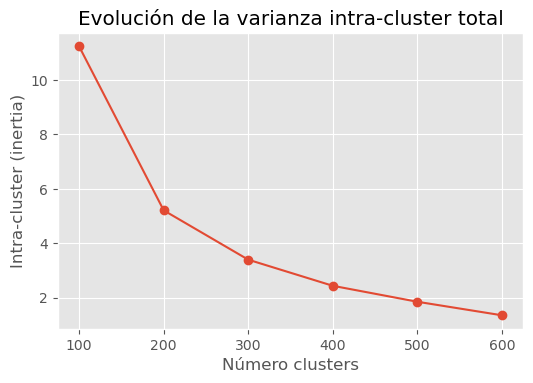

In [42]:
range_n_clusters = [100,200,300,400,500,600]
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

In [45]:
modelo_kmeans = KMeans(n_clusters=300, n_init=25, random_state=123)
y_predict = modelo_kmeans.fit_predict(X=X_scaled)

In [58]:
df["cluster"] = y_predict
df.head()

,id,lon,lat,area_m,area_km,media_boletas,media_clientes,media_cajas,ventas,cajas,media_caja_por_venta,clientes,media_caja_por_cliente,cluster
0,89b3218a69bffff,-68.030844,-16.577684,111550.134970,0.111550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,89b3218b003ffff,-68.073169,-16.608993,111596.259373,0.111596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134
2,89b3218b007ffff,-68.070413,-16.610737,111590.812619,0.111591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
3,89b3218b017ffff,-68.070192,-16.607459,111592.591714,0.111593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134
4,89b3218b023ffff,-68.067879,-16.615759,111583.584631,0.111584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277


In [64]:
linear = cm.LinearColormap(["blue", "yellow", "red"], vmin=df['cluster'].min(), vmax=df['cluster'].max())
linear

In [65]:
for row in df.itertuples():
    folium.CircleMarker(
        location = [row.lat, row.lon],
        radius = 3,
        fill = True,
        color = linear(row.cluster),
    ).add_to(mapa)
mapa